In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import pandas as pd
import numpy as np
from scipy import optimize
from scipy.stats import sem, pearsonr, linregress
import math

import os
import sys

import matplotlib.pyplot as plt
import matplotlib.ticker
from venn import venn, pseudovenn
import seaborn as sns
from matplotlib.collections import PathCollection

from Bio import SeqIO, SeqUtils
from Bio.SeqUtils.ProtParam import ProteinAnalysis

from addict import Dict
import json

import matplotlib.ticker as mticker
import matplotlib.cm as cm
from matplotlib.patches import Rectangle, Patch

In [4]:
import proteomics_functions as prot_fun

sys.path.append("/home/chase/codes/python_functions/")
import plotting as my_plot

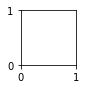

In [5]:
fig, ax = my_plot.instantiate_fig(1, 1)

# Prep data

In [11]:
df_master = pd.read_csv('./generated_tables/swath_master_df_ppm.csv')
df_plot = df_master.drop(columns=['accn', 'name'])

resin_names = {'cq':'Capto Q', 'xq':'Poros XQ', 'hq':'Poros 50 HQ'}
frac_names = {'a5':'A5', 'b12':'B12', 'd9':'D9', 'g12':'G12', 'eluate':'Adsorbate'}
percent_loading = {'a5':'5%', 'b12':'28%', 'd9':'53%', 'g12':'99%', 'eluate':'Adsorbate'}

new_names = []
for col in df_plot.columns:
    resin = col[:2]
    frac = col[3:]
    new_names.append(f'{resin_names[resin]}\n{percent_loading[frac]}')
    
df_plot.columns = new_names


df_plot = np.log10(df_plot)
df_plot.replace(-1*np.inf, np.nan, inplace=True)

In [12]:
## Ad hoc
min_val = math.floor(min(df_plot.min()))
max_val = math.ceil(max(df_plot.max()))

# I can control the plotting with xdata, ydata like this
def corrfunc(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    not_nan_indeces = ~np.isnan(x)&~np.isnan(y)
    x = x[not_nan_indeces]
    y = y[not_nan_indeces]
    r, pvalue = pearsonr(x, y)
#     print(pvalue)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.1, .87), xycoords=ax.transAxes)

def plot_unity(xdata, ydata, **kwargs):
    points = np.linspace(min_val, max_val, 100)
    plt.gca().plot(points, points, color='k', marker=None, linestyle='--', linewidth=1.0)
    
def plot_linear(x, y, **kwargs):
    not_nan_indeces = ~np.isnan(x)&~np.isnan(y)
    x = x[not_nan_indeces]
    y = y[not_nan_indeces]
    regression = linregress(x, y)
    x_vals = np.linspace(min_val, max_val, 100)
    y_vals = regression.slope * x_vals + regression.intercept
    plt.gca().plot(x_vals, y_vals, color='k', marker=None, linestyle='--', linewidth=1.0)

def set_axes_off_diag(xdata, ydata, **kwargs):
    plt.gca().set_xlim(min_val, max_val)
    plt.gca().set_ylim(min_val, max_val)
    
def set_axes_diag(xdata, **kwargs):
    plt.gca().set_xlim(min_val, max_val)

In [16]:
# sns.set_context("paper", rc={"font.size":16,"axes.titlesize":18,"axes.labelsize":16,"axes.ticklabelsize":16})
sns.set_context("notebook", font_scale=1.8)

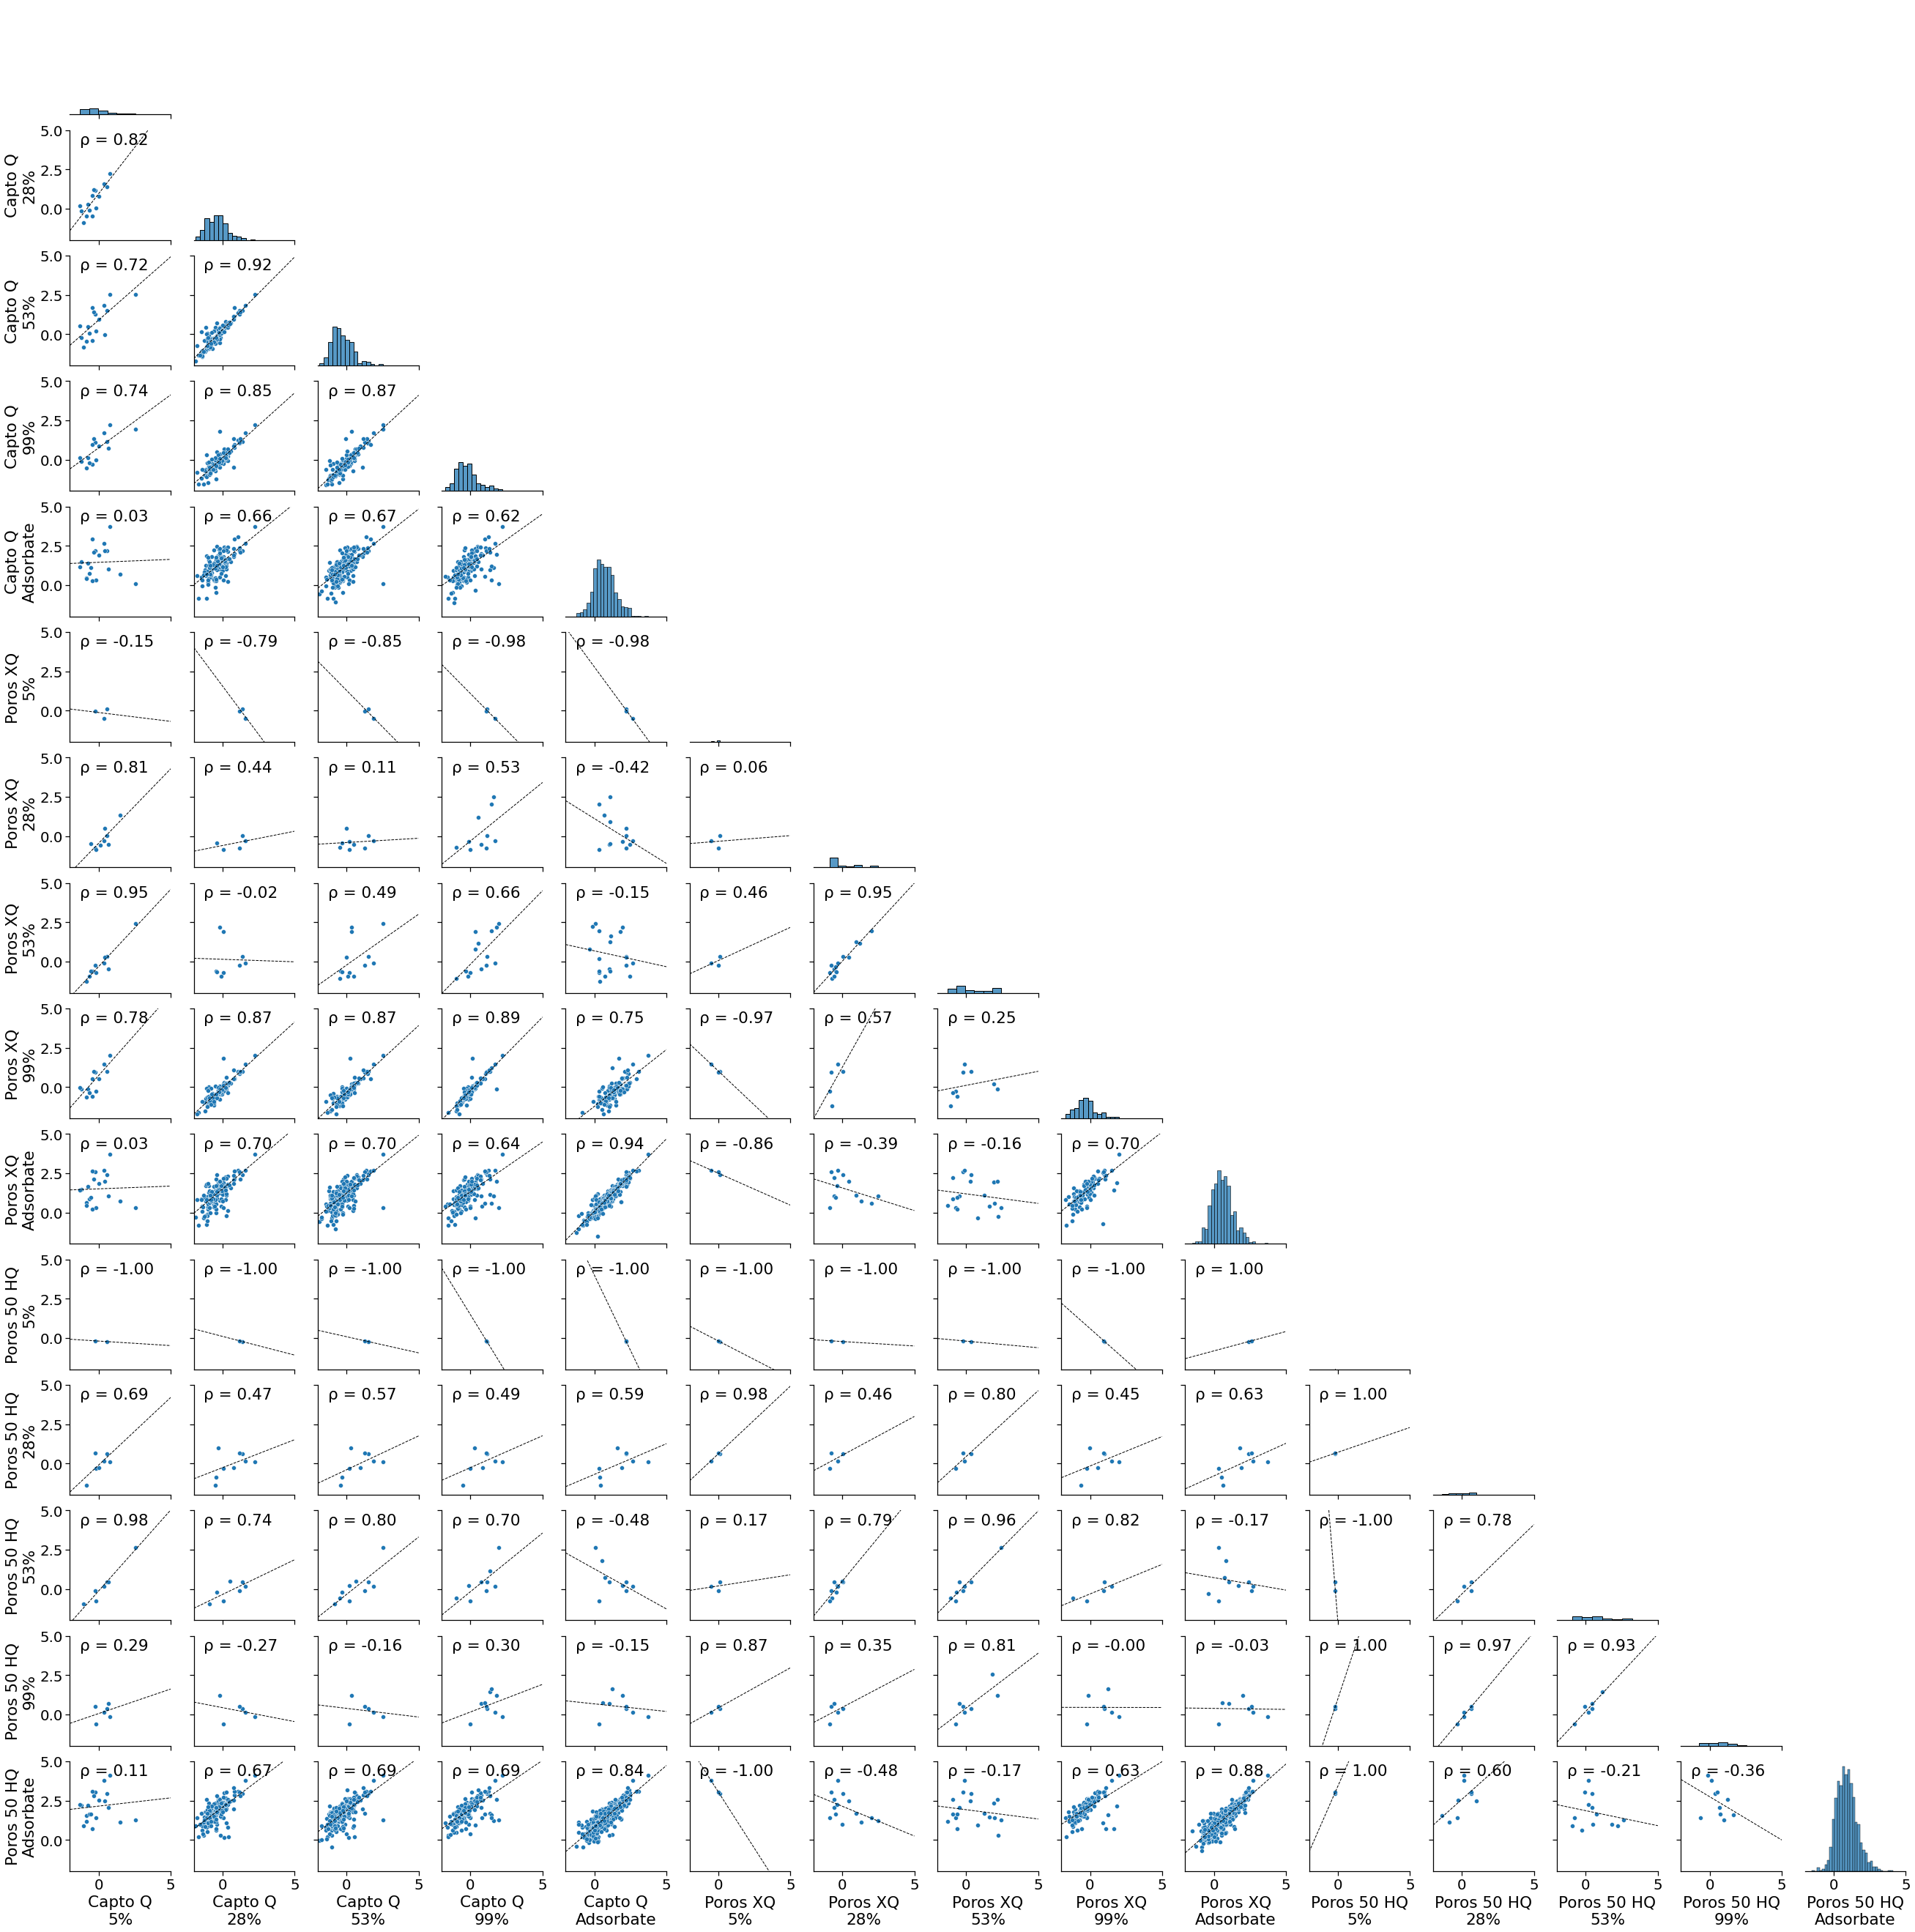

In [17]:
grid = sns.pairplot(df_plot, corner=True)

grid.map_offdiag(plot_linear)
grid.map_offdiag(set_axes_off_diag)
grid.map_offdiag(corrfunc)
grid.map_diag(set_axes_diag)

fig = grid.fig
fig.patch.set_alpha(1)
fig.savefig('./images/8_pairplot_log10_mass_frac_ppm.png', dpi=300)